# Finding Heavy Traffic Indicators on I-94

In this project, we are going to analyze a [dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) on westbound traffic on the I-94 Interstate Highway. The data was recorded at a station halfway between Minneapolis and Saint Paul.

Our goal is to determine indicators of heavy traffic on I-94, whether it be the type of weather, time of day, day of the week, etc.

In [1]:
import pandas as pd
i94_traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
i94_traffic.info()
pd.options.mode.chained_assignment = None  # default = 'warn'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [2]:
i94_traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
i94_traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


The dataset comprises 48,203 rows and 9 columns. It has no null values. We have data from `2012-10-02 09:00:00` to `2018-09-30 23:00:00`. The temperature is reported in Kelvin. We will change it to be Celsius.

In [4]:
i94_traffic['temp'] = i94_traffic['temp'] - 273.15

In [5]:
i94_traffic.head() # The temperature changed from Kelvin to Celsius.

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,15.13,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,16.21,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,16.43,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,16.98,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,17.99,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## Data Exploration

Let's see the distribution of the `traffic_volume` column.

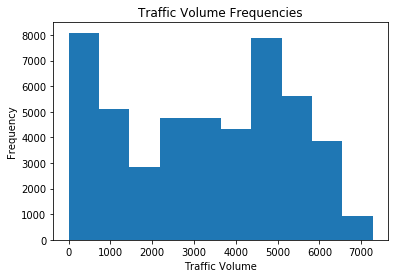

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(i94_traffic['traffic_volume']) # Apply labels and a title.
plt.title('Traffic Volume Frequencies')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.show()

No clear distribution in the graph. The highest frequencies of traffic volumes appear to be from about 0-750 and 4,500-5,250, being around 8,000. With similar frequencies being at different levels of traffic volume, it is possible that these differences are due to it being daytime or nighttime. Let's check other variables.

In [7]:
i94_traffic.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,8.055870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,-273.150000,0.000000,0.000000,0.000000,0.000000
25%,-0.990000,0.000000,0.000000,1.000000,1193.000000
50%,9.300000,0.000000,0.000000,64.000000,3380.000000
75%,18.656000,0.000000,0.000000,90.000000,4933.000000
max,36.920000,9831.300000,0.510000,100.000000,7280.000000


The highest temperature that occured appears to be 36.92°C. The highest traffic volume reported is 7,280. The greatest amount of rainfall in a given hour was 9831.3 millimeters, or 387.1 inches, which has never occurred before. It is likely to be an outlier we should ignore.

We will further investigate the differences found in the histogram we made by dividing the data into daytime (7 AM to 7 PM) and nighttime (7 PM to 7 AM).

In [8]:
i94_traffic['date_time'] = pd.to_datetime(i94_traffic['date_time']) # The date_time column was reported as object earlier.

In [9]:
day_bool = (i94_traffic['date_time'].dt.hour >= 7) & (i94_traffic['date_time'].dt.hour < 19) # From 7 AM to 7 PM
night_bool = (i94_traffic['date_time'].dt.hour < 7) | (i94_traffic['date_time'].dt.hour >= 19) # From 7 PM to 7 AM
d_i94 = i94_traffic[day_bool]
n_i94 = i94_traffic[night_bool]

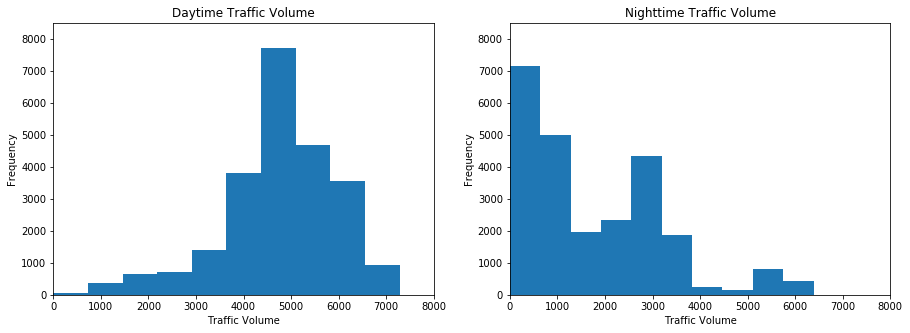

In [10]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.hist(d_i94['traffic_volume'])
plt.title('Daytime Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.xlim([0, 8000])
plt.ylim([0, 8500])

plt.subplot(1, 2, 2)
plt.hist(n_i94['traffic_volume'])
plt.title('Nighttime Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.xlim([0, 8000])
plt.ylim([0, 8500])

plt.show()

It appears our guess about the differences was right--there appears to be more traffic during the day than during the night. Let's investigate how traffic volume changes based on what month, day of the week, and what time of day it is.

### Traffic Volume by Month

In [11]:
d_i94['month'] = d_i94['date_time'].dt.month
by_month = d_i94.groupby('month').mean()
by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

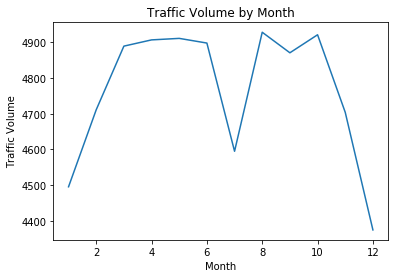

In [22]:
by_month['traffic_volume'].plot.line()
plt.title('Traffic Volume by Month')
plt.xlabel('Month')
plt.ylabel('Traffic Volume')
plt.show()

Traffic on the I-94 looks to be the most busy during the warmer months on average, with the exception being July. Let's find out why that is.

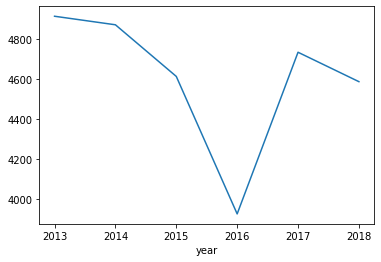

In [13]:
d_i94['year'] = d_i94['date_time'].dt.year
july_traffic = d_i94[d_i94['month'] == 7]
july_traffic.groupby('year').mean()['traffic_volume'].plot.line()

It appears that only July 2016 was an exception; July tends to be busy as well. Turns out, construction was occurring during July 2016 according to [this article](https://www.crainsdetroit.com/article/20160728/NEWS/160729841/weekend-construction-i-96-us-23-bridge-work-i-94-lane-closures-i-696).

In [14]:
d_i94['dayofweek'] = d_i94['date_time'].dt.dayofweek
by_dayofweek = d_i94.groupby('dayofweek').mean()
by_dayofweek['traffic_volume'] # 0 is Monday, 6 is Sunday

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

### Traffic Volume by Week

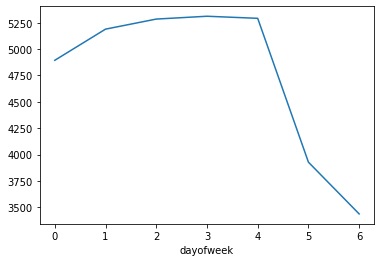

In [15]:
by_dayofweek['traffic_volume'].plot.line()
plt.show()

It appears that traffic is most congested on the weekdays, compared to the weekend. This is most likely due to most people working on weekdays than the weekend. Let's split the data between the work week and the weekend.

### Traffic Volume by Hour

In [16]:
d_i94['hour'] = d_i94['date_time'].dt.hour
workdays = d_i94.copy()[d_i94['dayofweek'] <= 4] # 4 is Friday
weekend = d_i94.copy()[d_i94['dayofweek'] >= 5] # 5 is Saturday
by_hour_business = workdays.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print(by_hour_business['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


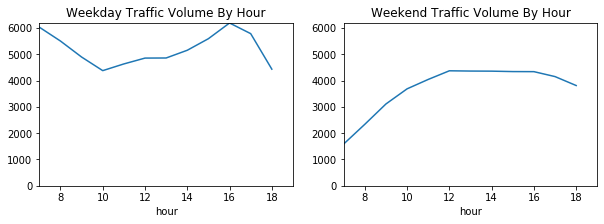

In [17]:
plt.figure(figsize = (10, 3))

plt.subplot(1, 2, 1)
by_hour_business['traffic_volume'].plot.line()
plt.title('Weekday Traffic Volume By Hour')
plt.xlim([7, 19])
plt.ylim([0, 6200])

plt.subplot(1, 2, 2)
by_hour_weekend['traffic_volume'].plot.line()
plt.title('Weekend Traffic Volume By Hour')
plt.xlim([7, 19])
plt.ylim([0, 6200])

plt.show()

On the weekdays, traffic starts high at least 6,000 at 7 in the morning, decreasing as it reaches the early afternoon, and spiking again at 5 PM, around when people are clocking out of work. On the weekends, traffic starts low, with a steady increase until it starts to tapers off at about 4,400 around noon.

To summarize, traffic is most busy from March to November, and least busy from November to March. The rush hours on the weekdays are 7 AM and 5 PM, but there are none on the weekend.

Now that remains to answer is: does weather correlate with traffic volume?

### Correlation Between Traffic Volume and Weather

In [18]:
d_i94.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

The column with the strongest correlation is temp, with a correlation value of 0.13.

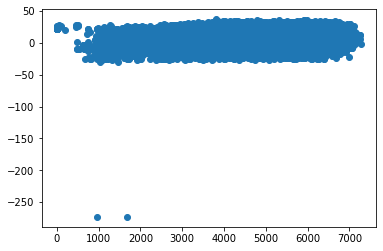

In [19]:
plt.scatter(d_i94['traffic_volume'], d_i94['temp'])

It appears there is no strong visual correlation between traffic volume and temperature. What about the `weather_main` and `weather_description` columns?

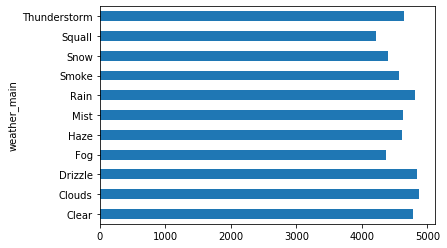

In [20]:
by_weather_main = d_i94.groupby('weather_main').mean()

by_weather_main['traffic_volume'].plot.barh()
plt.show()

None of the weather types exceed 5,000 cars in traffic volume, and the results are pretty close together. Let's see if this is also the case with `weather_description`.

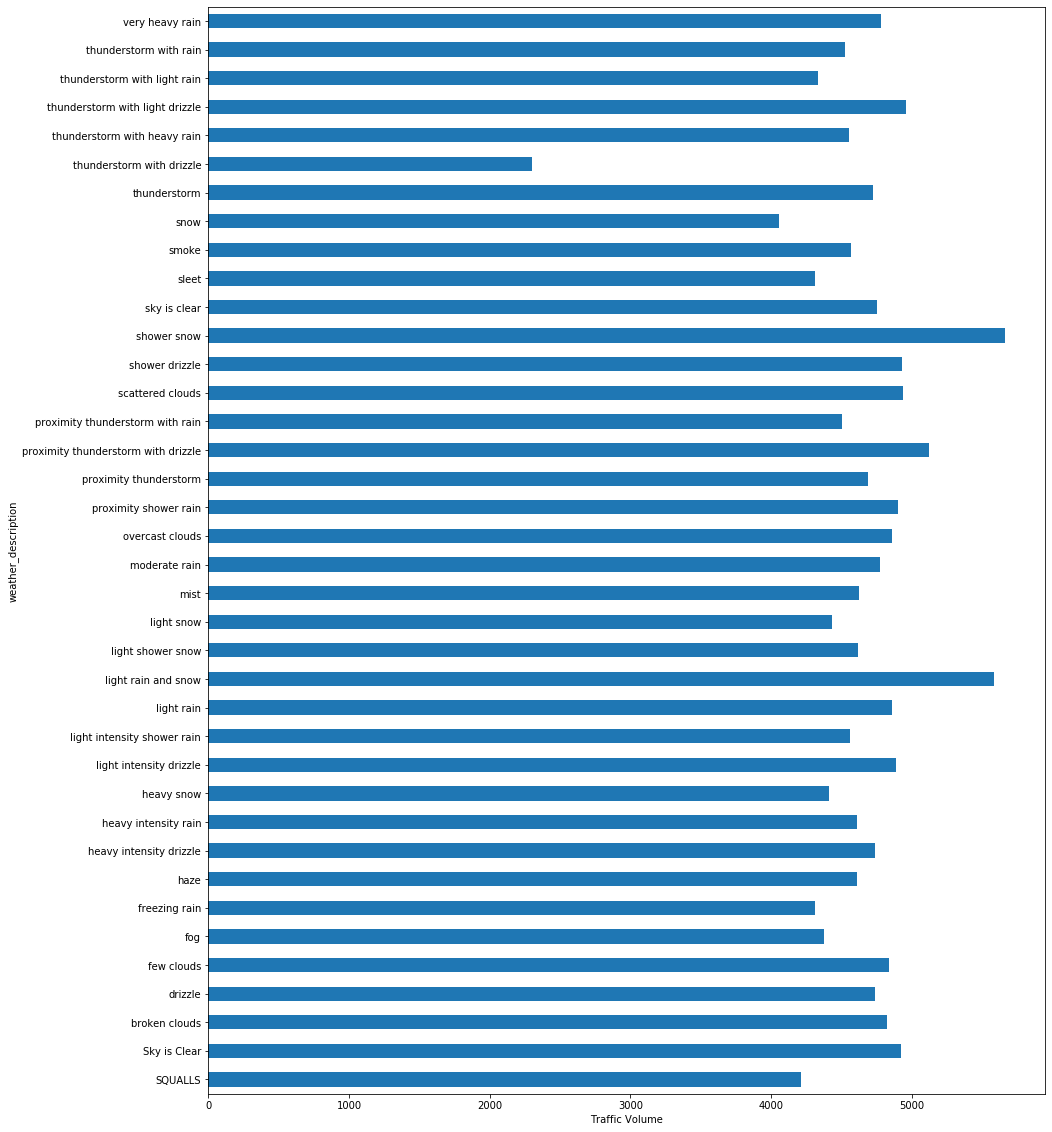

In [23]:
by_weather_description = d_i94.groupby('weather_description').mean()

plt.figure(figsize = (15, 20))
by_weather_description['traffic_volume'].plot.barh()
plt.xlabel('Traffic Volume')
plt.show()

`Shower snow`, `Light rain and snow`, and `Proximity thunderstorm with drizzle` all appear to exceed 5,000 cars in traffic volume. These are all relatively bad weather types, but not as bad as squalls and heavy snow. These may be instances where people drive instead of ride a bike or walk.

## Conclusion

Our initial goal was to determine heavy traffic indicators on the I-94. We approached this by examining traffic volume differences by year, month, day, hour, and weather. We found traffic to be the most busy March to November, with the exception being July due to construction taking place in 2016. Weekdays have more traffic volume than weekends, and have rush hours at 7 AM and 5 PM.

We found no correlation between traffic volume and temperature. We found that `Shower snow`, `Light rain and snow`, and `Proximity thunderstorm with drizzle` weather types had traffic volumes over 5,000, however there aren't any conclusions we can draw from weather type.